# This is an upgraded version of the scBERT

## We are planning to incorporate these things:

### Improvements to the Encoder block
1. Grouped Multi Query Attention
2. RMS Norm in place of LayerNorm for faster training
3. Flash attention 2.0
4. SwiGLU/SiLU in place of ReLU/GLU - done
5. Gene coexpression

### Improvements to improve parameter count while reducing computational cost
1. Mixtral of Experts

### Improvements to training stratergy
2. Improved Token Embeddings
1. Improved masking

### For Faster training
1. Mixed precision training - done
2. Distributed Data Parallel Training - done
3. Faster Data Loading using MultDL
4. Adafactor - https://huggingface.co/docs/transformers/main/en/perf_train_gpu_one#optimizer-choice
5. Torch compile - https://huggingface.co/docs/transformers/main/en/perf_train_gpu_one#using-torchcompile
6. Data preloading - done

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%pip install mixture_of_experts
%pip install scanpy
%pip install accelerate

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [3]:
import scanpy as sc
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from mixture_of_experts import MoE
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import random
from tqdm import tqdm
from functools import reduce
from torch.optim import AdamW
import math
import matplotlib.pyplot as plt
from accelerate import Accelerator

In [4]:
accelerator = Accelerator(mixed_precision='fp16')

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
torch.backends.cuda.enable_flash_sdp(True)

In [7]:
class FlashAttentionBlock(nn.Module):
    def __init__(self, d_model: int, h: int) -> None:
        super().__init__()
        self.d_model = d_model
        self.h = h
        assert d_model % h ==0, "d_model is not divisble by h"
        self.d_k = d_model // h

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)


    def forward(self, q, k, v):
        query = self.w_q (q) # (batch, seq_len, d_model) -> (batch, seq_len, d_model)
        key = self.w_k(k) # (batch, seq_len, d_model) -> (batch, seq_len, d_model)
        value = self.w_v(v) # (batch, seq_len, d_model) -> (batch, seq_len, d_model)

        # Test code
        # query = q
        # key = k
        # value = v

        # (batch, seq_len, d_model) -> (Batch, seq_len, h, d_k) -> (Batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1,2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1,2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1,2)

        x = F.scaled_dot_product_attention(query,key,value, dropout_p=0.1)

        # (Batch, h, seq_len, d_k) -> (Batch, seq_len, h, d_k) -> (Batch, seq_len, d_model)
        x =  x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # (Batch, seq_len, d_model)  -> (Batch, seq_len, d_model)
        return self.w_o(x)

In [8]:
class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

In [9]:
moe = MoE(
    dim = 200,
    num_experts =  4,               # increase the experts (# parameters) of your model without increasing computation
    hidden_dim = 200 * 4,           # size of hidden dimension in each expert, defaults to 4 * dimension
    activation = nn.SiLU,      # use your preferred activation, will default to GELU
    second_policy_train = 'random', # in top_2 gating, policy for whether to use a second-place expert
    second_policy_eval = 'random',  # all (always) | none (never) | threshold (if gate value > the given threshold) | random (if gate value > threshold * random_uniform(0, 1))
    second_threshold_train = 0.2,
    second_threshold_eval = 0.2,
    capacity_factor_train = 1.25,   # experts have fixed capacity per batch. we need some extra capacity in case gating is not perfectly balanced.
    capacity_factor_eval = 2.,      # capacity_factor_* should be set to a value >=1
    loss_coef = 1e-2                # multiplier on the auxiliary expert balancing auxiliary loss
)

In [10]:
class Encoder(nn.Module):
  def __init__(self, local_heads, d_model, hidden_ff_model):
    super().__init__()
    # Embedding dimension = 200, Local_Attention heads = 10
    self.attention = FlashAttentionBlock(d_model= d_model, h=local_heads)
    self.attention_norm = RMSNorm(dim =d_model)
    self.ff_norm = RMSNorm(dim=d_model)
    self.feed_forward = MoE(dim =d_model, num_experts=8, hidden_dim= hidden_ff_model,activation = nn.SiLU, second_policy_train = 'random', second_policy_eval = 'random', second_threshold_train = 0.2, second_threshold_eval = 0.2, capacity_factor_train = 1.25,capacity_factor_eval = 2., loss_coef = 1e-2)


  def forward(self, x):
    x_normed = self.attention_norm(x)
    # print(x_normed.shape)
    r = self.attention(x_normed, x_normed, x_normed)
    h = x + r
    r, _ = self.feed_forward(self.ff_norm(h))
    out = h + r
    return out

In [11]:
class Gene2VecPositionalEmbedding(nn.Module):
    def __init__(self):
        super().__init__()

        gene2vec_weight = np.load('/content/drive/MyDrive/scFasterBERT/data/gene2vec_16906.npy')
        gene2vec_weight = np.concatenate((gene2vec_weight, np.zeros((1, gene2vec_weight.shape[1]))), axis=0)
        gene2vec_weight = torch.from_numpy(gene2vec_weight)
        self.emb = nn.Embedding.from_pretrained(gene2vec_weight)

    def forward(self, x):
        t = torch.arange(x.shape[1], device = device)
        return self.emb(t)

In [12]:
#max_seq_len =16907
class scBERT2(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_emb = nn.Embedding(7, 200)
        self.pos_emb = Gene2VecPositionalEmbedding()
        self.layer1 = Encoder(local_heads=10,d_model=200, hidden_ff_model=400)
        # self.layer2 = Encoder(local_heads=10,d_model=200, hidden_ff_model=400)
        # self.layer3 = Encoder(local_heads=10,d_model=200, hidden_ff_model=400)
        # self.layer4 = Encoder(local_heads=10,d_model=200, hidden_ff_model=400)
        # self.layer5 = Encoder(local_heads=10,d_model=200, hidden_ff_model=400)
        # self.layer6 = Encoder(local_heads=10,d_model=200, hidden_ff_model=400)
        self.norm = RMSNorm(200)
        self.classifier = nn.Linear(in_features=200, out_features=7)

    def forward(self, x):
    # x = x.type(torch.int32)
        pos_emb = self.pos_emb(x)
        x = self.token_emb(x.int())
        # print(x.shape)
        x += pos_emb
        x = self.layer1(x)
        # x = self.layer2(x)
        # x = self.layer3(x)
        # x = self.layer4(x)
        # x = self.layer5(x)
        # x = self.layer6(x)
        x = self.classifier(self.norm(x))
        return x

In [13]:
scbert = scBERT2()

In [14]:
sum(p.numel() for p in scbert.parameters() if p.requires_grad)

1445807

In [15]:
state_dict = scbert.state_dict()

In [16]:
ckpt = torch.load('/content/drive/MyDrive/scFasterBERT/panglao_pretrain.pth')

In [17]:
state_dict['layer1.attention.w_q.weight']=ckpt['model_state_dict']['performer.net.layers.0.0.fn.to_q.weight']
state_dict['layer1.attention.w_k.weight']=ckpt['model_state_dict']['performer.net.layers.0.0.fn.to_k.weight']
state_dict['layer1.attention.w_v.weight']=ckpt['model_state_dict']['performer.net.layers.0.0.fn.to_v.weight']
state_dict['layer1.attention.w_o.weight']=ckpt['model_state_dict']['performer.net.layers.0.0.fn.to_out.weight']
state_dict['layer1.attention.w_o.bias']=ckpt['model_state_dict']['performer.net.layers.0.0.fn.to_out.bias']

state_dict['layer2.attention.w_q.weight']=ckpt['model_state_dict']['performer.net.layers.1.0.fn.to_q.weight']
state_dict['layer2.attention.w_k.weight']=ckpt['model_state_dict']['performer.net.layers.1.0.fn.to_k.weight']
state_dict['layer2.attention.w_v.weight']=ckpt['model_state_dict']['performer.net.layers.1.0.fn.to_v.weight']
state_dict['layer2.attention.w_o.weight']=ckpt['model_state_dict']['performer.net.layers.1.0.fn.to_out.weight']
state_dict['layer2.attention.w_o.bias']=ckpt['model_state_dict']['performer.net.layers.1.0.fn.to_out.bias']

state_dict['layer3.attention.w_q.weight']=ckpt['model_state_dict']['performer.net.layers.2.0.fn.to_q.weight']
state_dict['layer3.attention.w_k.weight']=ckpt['model_state_dict']['performer.net.layers.2.0.fn.to_k.weight']
state_dict['layer3.attention.w_v.weight']=ckpt['model_state_dict']['performer.net.layers.2.0.fn.to_v.weight']
state_dict['layer3.attention.w_o.weight']=ckpt['model_state_dict']['performer.net.layers.2.0.fn.to_out.weight']
state_dict['layer3.attention.w_o.bias']=ckpt['model_state_dict']['performer.net.layers.2.0.fn.to_out.bias']

state_dict['layer4.attention.w_q.weight']=ckpt['model_state_dict']['performer.net.layers.3.0.fn.to_q.weight']
state_dict['layer4.attention.w_k.weight']=ckpt['model_state_dict']['performer.net.layers.3.0.fn.to_k.weight']
state_dict['layer4.attention.w_v.weight']=ckpt['model_state_dict']['performer.net.layers.3.0.fn.to_v.weight']
state_dict['layer4.attention.w_o.weight']=ckpt['model_state_dict']['performer.net.layers.3.0.fn.to_out.weight']
state_dict['layer4.attention.w_o.bias']=ckpt['model_state_dict']['performer.net.layers.3.0.fn.to_out.bias']

state_dict['layer5.attention.w_q.weight']=ckpt['model_state_dict']['performer.net.layers.4.0.fn.to_q.weight']
state_dict['layer5.attention.w_k.weight']=ckpt['model_state_dict']['performer.net.layers.4.0.fn.to_k.weight']
state_dict['layer5.attention.w_v.weight']=ckpt['model_state_dict']['performer.net.layers.4.0.fn.to_v.weight']
state_dict['layer5.attention.w_o.weight']=ckpt['model_state_dict']['performer.net.layers.4.0.fn.to_out.weight']
state_dict['layer5.attention.w_o.bias']=ckpt['model_state_dict']['performer.net.layers.4.0.fn.to_out.bias']

state_dict['layer6.attention.w_q.weight']=ckpt['model_state_dict']['performer.net.layers.5.0.fn.to_q.weight']
state_dict['layer6.attention.w_k.weight']=ckpt['model_state_dict']['performer.net.layers.5.0.fn.to_k.weight']
state_dict['layer6.attention.w_v.weight']=ckpt['model_state_dict']['performer.net.layers.5.0.fn.to_v.weight']
state_dict['layer6.attention.w_o.weight']=ckpt['model_state_dict']['performer.net.layers.5.0.fn.to_out.weight']
state_dict['layer6.attention.w_o.bias']=ckpt['model_state_dict']['performer.net.layers.5.0.fn.to_out.bias']


In [18]:
# scbert.load_state_dict(state_dict)

# Training

In [30]:
SEED = 2021
EPOCHS = 3
BATCH_SIZE = 1
LEARNING_RATE = 1e-4
GRADIENT_ACCUMULATION = 60
SEQ_LEN = 16907
VALIDATE_EVERY = 1
CLASS = 7
MASK_PROB = 0.15
REPLACE_PROB = 0.9
RANDOM_TOKEN_PROB = 0.
MASK_TOKEN_ID = CLASS - 1
PAD_TOKEN_ID = CLASS - 1
MASK_IGNORE_TOKEN_IDS = [0]
POS_EMBED_USING = True

In [20]:
# get the random prob matrix and True means smaller than prob threshold
def prob_mask_like(t, prob):
    return torch.zeros_like(t).float().uniform_(0, 1) < prob

# get the mask matrix which cannot be masked
def mask_with_tokens(t, token_ids):
    init_no_mask = torch.full_like(t, False, dtype=torch.bool)
    mask = reduce(lambda acc, el: acc | (t == el), token_ids, init_no_mask)
    return mask

def get_mask_subset_with_prob(mask, prob):
    batch, seq_len, device = *mask.shape, mask.device
    max_masked = math.ceil(prob * seq_len)      # num of mask of a single sequence in average
    num_tokens = mask.sum(dim=-1, keepdim=True)     # num of pure tokens of each sequence except special tokens
    mask_excess = torch.cat((torch.zeros(0), torch.arange(mask.size(-1)).repeat(mask.size(0)))).reshape(mask.size(0),mask.size(-1)).to(device)
    mask_excess = (mask_excess >= (num_tokens * prob).ceil())        # only 15% of pure tokens can be masked
    mask_excess = mask_excess[:, :max_masked]       # get difference between 15% of pure tokens and 15% of all tokens
    rand = torch.rand((batch, seq_len), device=device).masked_fill(~mask, -1e9)     # rand (0-1) as prob, special token use -1e9
    _, sampled_indices = rand.topk(max_masked, dim=-1)      # get index of topk prob to mask
    sampled_indices = (sampled_indices + 1).masked_fill_(mask_excess, 0)        # delete difference of mask not pure
    new_mask = torch.zeros((batch, seq_len + 1), device=device)     # get (batch, seq_len) shape zero matrix
    new_mask.scatter_(-1, sampled_indices, 1)       # set masks in zero matrix as 1
    return new_mask[:, 1:].bool()       # the final mask, True is mask

def data_mask(data,
    mask_prob = MASK_PROB,
    replace_prob = REPLACE_PROB,
    num_tokens = None,
    random_token_prob = RANDOM_TOKEN_PROB,
    mask_token_id = MASK_TOKEN_ID,
    pad_token_id = PAD_TOKEN_ID,
    mask_ignore_token_ids = MASK_IGNORE_TOKEN_IDS
):
    mask_ignore_token_ids = set([*mask_ignore_token_ids, pad_token_id])
    # do not mask [pad] tokens, or any other tokens in the tokens designated to be excluded ([cls], [sep])
    # also do not include these special tokens in the tokens chosen at random
    no_mask = mask_with_tokens(data, mask_ignore_token_ids)   # ignore_token as True, will not be masked later
    mask = get_mask_subset_with_prob(~no_mask, mask_prob)      # get the True/False mask matrix
    # get mask indices
    ## mask_indices = torch.nonzero(mask, as_tuple=True)   # get the index of mask(nonzero value of mask matrix)
    # mask input with mask tokens with probability of `replace_prob` (keep tokens the same with probability 1 - replace_prob)
    masked_input = data.clone().detach()
    # if random token probability > 0 for mlm
    if random_token_prob > 0:
        assert num_tokens is not None, 'num_tokens keyword must be supplied when instantiating MLM if using random token replacement'
        random_token_prob = prob_mask_like(data, random_token_prob)       # get the mask matrix of random token replace
        random_tokens = torch.randint(0, num_tokens, data.shape, device=data.device)     # generate random token matrix with the same shape as in
        random_no_mask = mask_with_tokens(random_tokens, mask_ignore_token_ids)        # not masked matrix for the random token matrix
        random_token_prob &= ~random_no_mask        # get the pure mask matrix of random token replace
        random_indices = torch.nonzero(random_token_prob, as_tuple=True)        # index of random token replace
        masked_input[random_indices] = random_tokens[random_indices]        # replace some tokens by random token
    # [mask] input
    replace_prob = prob_mask_like(data, replace_prob)     # get the mask matrix of token being masked
    masked_input = masked_input.masked_fill(mask * replace_prob, mask_token_id)        # get the data has been masked by mask_token
    # mask out any tokens to padding tokens that were not originally going to be masked
    labels = data.masked_fill(~mask, pad_token_id)        # the label of masked tokens
    return masked_input, labels

In [21]:
class SCDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __getitem__(self, index):
        rand_start = random.randint(0, self.data.shape[0]-1)
        full_seq = self.data[rand_start].toarray()[0]
        full_seq[full_seq > (CLASS - 2)] = CLASS - 2
        full_seq = torch.from_numpy(full_seq).long()
        full_seq = torch.cat((full_seq, torch.tensor([0]))).to(device)
        return full_seq

    def __len__(self):
        return self.data.shape[0]

In [22]:
data = sc.read_h5ad('/content/drive/MyDrive/scFasterBERT/data/panglao_human_smallest.h5ad')
data = data.X
data_train, data_val = train_test_split(data, test_size=0.1,random_state=SEED)

train_dataset = SCDataset(data_train)
val_dataset = SCDataset(data_val)
len(val_dataset)

10

In [23]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
len(val_loader), len(train_loader)

(10, 90)

In [24]:
optimizer = AdamW(scbert.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN_ID, reduction='mean').to(device)
softmax = nn.Softmax(dim=-1)
scaler = torch.cuda.amp.GradScaler()

In [25]:
train_loader, val_loader, scbert, optimizer = accelerator.prepare(train_loader, val_loader, scbert, optimizer)

In [26]:
# train_losses =[]
# train_accuracies = []
# valid_losses =[]
# valid_accuracies = []

# def train(model):
#     softmax = nn.Softmax(dim=-1)
#     train_losses =[]
#     train_accuracies = []
#     valid_losses =[]
#     valid_accuracies = []
#     for i in range(1, EPOCHS+1):
#         model.train()
#         running_loss = 0.0
#         cum_acc = 0.0
#         for index, data in enumerate(tqdm(train_loader)):
#             index += 1
#             data = data.to(device)
#             data, labels = data_mask(data)
#             logits = model(data)
#             loss = loss_fn(logits.transpose(1, 2), labels)
#             loss.backward()
#             if index % GRADIENT_ACCUMULATION != 0:
#               torch.nn.utils.clip_grad_norm_(model.parameters(), int(1e2))
#               optimizer.step()
#               optimizer.zero_grad()
#             running_loss += loss.item()
#             final = softmax(logits)[..., 1:-1]
#             final = final.argmax(dim=-1) + 1
#             pred_num = (labels != PAD_TOKEN_ID).sum(dim=-1)
#             correct_num = ((labels != PAD_TOKEN_ID) * (final == labels)).sum(dim=-1)
#             cum_acc += torch.true_divide(correct_num, pred_num).mean().item()

#         epoch_loss = running_loss / index
#         epoch_acc = 100 * cum_acc / index
#         train_losses.append(epoch_loss)
#         train_accuracies.append(epoch_acc)
#         print(f'    ==  Epoch: {i} | Training Loss: {epoch_loss:.6f} | Accuracy: {epoch_acc:6.4f}%  ==')

#         if i % VALIDATE_EVERY == 0:
#             model.eval()
#             running_loss = 0.0
#             predictions = []
#             truths = []
#             with torch.no_grad():
#                 for index, data in tqdm(enumerate(val_loader)):
#                     index += 1
#                     data = data.to(device)
#                     data, labels = data_mask(data)
#                     logits = model(data)
#                     loss = loss_fn(logits.transpose(1, 2), labels)
#                     running_loss += loss.item()
#                     softmax = nn.Softmax(dim=-1)
#                     final = softmax(logits)[..., 1:-1]
#                     final = final.argmax(dim=-1) + 1
#                     predictions.append(final)
#                     truths.append(labels)
#             val_loss = running_loss / index
#             correct_num = ((torch.cat(truths, dim=0) != PAD_TOKEN_ID) * (torch.cat(predictions, dim=0) == torch.cat(truths, dim=0))).sum().item()
#             val_num = (torch.cat(truths, dim=0) != PAD_TOKEN_ID).sum().item()
#             val_acc = 100 * correct_num / val_num
#             valid_losses.append(val_loss)
#             valid_accuracies.append(val_acc)
#             print(f'    ==  Epoch: {i} | Validation Loss: {val_loss:.6f} | Accuracy: {val_acc:6.4f}%  ==')

#     return train_losses, train_accuracies, valid_losses, valid_accuracies


In [27]:
# train_losses, train_accuracies, valid_losses, valid_accuracies = train(scbert)

In [34]:
def train2(model):
  softmax = nn.Softmax(dim=-1)
  train_losses =[]
  train_accuracies = []
  valid_losses =[]
  valid_accuracies = []
  for i in range(1, EPOCHS+1):
      model.train()
      running_loss = 0.0
      cum_acc = 0.0
      for index, data in enumerate(tqdm(train_loader)):
          index += 1
          data = data.to(device)
          data, labels = data_mask(data)
          logits = model(data)
          loss = loss_fn(logits.transpose(1, 2), labels)/ GRADIENT_ACCUMULATION
          accelerator.backward(loss)
          torch.nn.utils.clip_grad_norm_(model.parameters(), int(1e2))
          optimizer.step()
          # scheduler.step()
          optimizer.zero_grad()
          running_loss += loss.item()
          final = softmax(logits)[..., 1:-1]
          final = final.argmax(dim=-1) + 1
          pred_num = (labels != PAD_TOKEN_ID).sum(dim=-1)
          correct_num = ((labels != PAD_TOKEN_ID) * (final == labels)).sum(dim=-1)
          cum_acc += torch.true_divide(correct_num, pred_num).mean().item()
      epoch_loss = running_loss / index
      epoch_acc = 100 * cum_acc / index
      train_losses.append(epoch_loss)
      train_accuracies.append(epoch_acc)
      print(f'    ==  Epoch: {i} | Training Loss: {epoch_loss:.6f} | Accuracy: {epoch_acc:6.4f}%  ==')

      if i % VALIDATE_EVERY == 0:
          model.eval()
          running_loss = 0.0
          predictions = []
          truths = []
          with torch.no_grad():
              for index, data in enumerate(tqdm(val_loader)):
                  index += 1
                  data = data.to(device)
                  data, labels = data_mask(data)
                  logits = model(data)
                  loss = loss_fn(logits.transpose(1, 2), labels)
                  running_loss += loss.item()
                  softmax = nn.Softmax(dim=-1)
                  final = softmax(logits)[..., 1:-1]
                  final = final.argmax(dim=-1) + 1
                  predictions.append(final)
                  truths.append(labels)
          val_loss = running_loss / index
          correct_num = ((torch.cat(truths, dim=0) != PAD_TOKEN_ID) * (torch.cat(predictions, dim=0) == torch.cat(truths, dim=0))).sum().item()
          val_num = (torch.cat(truths, dim=0) != PAD_TOKEN_ID).sum().item()
          val_acc = 100 * correct_num / val_num
          valid_losses.append(val_loss)
          valid_accuracies.append(val_acc)
          print(f'    ==  Epoch: {i} | Validation Loss: {val_loss:.6f} | Accuracy: {val_acc:6.4f}%  ==')

  return train_losses, train_accuracies, valid_losses, valid_accuracies

In [35]:
train_losses, train_accuracies, valid_losses, valid_accuracies = train2(scbert)

100%|██████████| 90/90 [00:07<00:00, 11.79it/s]


    ==  Epoch: 1 | Training Loss: 0.013599 | Accuracy: 63.7817%  ==


100%|██████████| 10/10 [00:00<00:00, 18.36it/s]


    ==  Epoch: 1 | Validation Loss: 0.969208 | Accuracy: 53.8997%  ==


100%|██████████| 90/90 [00:07<00:00, 11.69it/s]


    ==  Epoch: 2 | Training Loss: 0.012320 | Accuracy: 72.3738%  ==


100%|██████████| 10/10 [00:00<00:00, 17.98it/s]


    ==  Epoch: 2 | Validation Loss: 1.094271 | Accuracy: 50.5913%  ==


100%|██████████| 90/90 [00:07<00:00, 11.69it/s]


    ==  Epoch: 3 | Training Loss: 0.011420 | Accuracy: 73.9028%  ==


100%|██████████| 10/10 [00:00<00:00, 18.20it/s]

    ==  Epoch: 3 | Validation Loss: 0.800928 | Accuracy: 73.4578%  ==


In [36]:
def plot_graphs(train_losses, train_accuracies, valid_losses, valid_accuracies):
  plt.plot(train_losses)
  plt.plot(train_accuracies)
  plt.plot(valid_losses)
  plt.plot(valid_accuracies)
  plt.legend(['train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy'])
  plt.title('Panglao_smallest')
  plt.show()

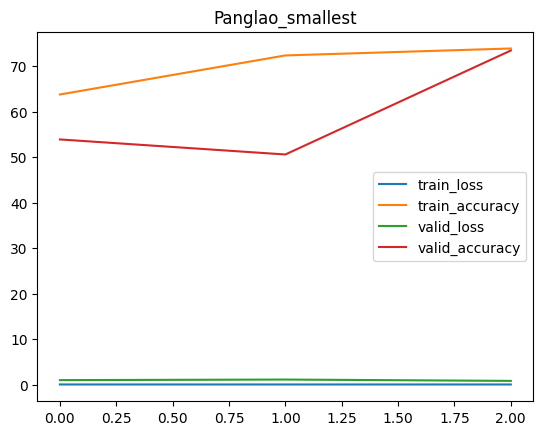

In [37]:
plot_graphs(train_losses, train_accuracies, valid_losses, valid_accuracies)